In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
import os
from sklearn.decomposition import PCA

from dredFISH.Design import PNMF
from dredFISH.Utils import basicu
from dredFISH.Utils.__init__plots import * 

import importlib
importlib.reload(PNMF)


<module 'dredFISH.Design.PNMF' from '/bigstore/GeneralStorage/fangming/projects/dredfish/packages/dredFISH/dredFISH/Design/PNMF.py'>

In [2]:
prj_dir = '/bigstore/GeneralStorage/fangming/projects/dredfish/'
dat_dir = prj_dir + 'data/'
res_dir = prj_dir + 'res_dpnmf/v_python'
print(res_dir)
fig_dir = prj_dir + 'figures/'

# data (old)
f = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_genes_matrix.h5ad'
adata = anndata.read_h5ad(f, backed='r') # library size normed (no log)
# X = np.array(adata.X.todense()).copy() # already library size normalized
# adata

# data (CPM with rep)
scrna_genes_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/res_dpnmf/smrt_withrep_X_subL5n100.npy'
cell_path        = '/bigstore/GeneralStorage/fangming/projects/dredfish/res_dpnmf/smrt_withrep_X_subL5n100_cells.csv'
clst_path        = '/bigstore/GeneralStorage/fangming/projects/dredfish/res_dpnmf/smrt_withrep_X_subL5n100_y_L5.npy'

/bigstore/GeneralStorage/fangming/projects/dredfish/res_dpnmf/v_python


In [3]:
# allen scrna matrix (CPM; only 10k genes)
X = np.load(scrna_genes_path, allow_pickle=True).T # cell by gene
cells = pd.read_csv(cell_path)['0'].values
# X.sum(axis=1)
y_l5 = np.load(clst_path, allow_pickle=True)

logX = np.log10(X+1) ## !!!
X.shape, y_l5.shape, cells.shape

((38200, 10861), (38200,), (38200,))

In [4]:
meta = adata.obs.copy()
meta = meta.loc[cells]
meta[['cluster_label', 'subclass_label', 'neighborhood_label', 'class_label']]

,cluster_label,subclass_label,neighborhood_label,class_label
SM-D9CZ6_S01_E1-50,259_L5 PT CTX,L5 PT CTX,PT,Glutamatergic
LS-15352_S16_E1-50,259_L5 PT CTX,L5 PT CTX,PT,Glutamatergic
SM-D9EPN_S55_E1-50,259_L5 PT CTX,L5 PT CTX,PT,Glutamatergic
SM-D9CZK_S30_E1-50,259_L5 PT CTX,L5 PT CTX,PT,Glutamatergic
SM-GE676_S016_E1-50,259_L5 PT CTX,L5 PT CTX,PT,Glutamatergic
...,...,...,...,...
SM-GE4XX_S291_E1-50,262_L4 RSP-ACA,L4 RSP-ACA,PT,Glutamatergic
SM-GE4XV_S182_E1-50,262_L4 RSP-ACA,L4 RSP-ACA,PT,Glutamatergic
SM-GE4WM_S007_E1-50,262_L4 RSP-ACA,L4 RSP-ACA,PT,Glutamatergic
SM-GE4XV_S189_E1-50,262_L4 RSP-ACA,L4 RSP-ACA,PT,Glutamatergic


In [5]:
# get the S matrix
ctrds_l3, types_l3 = basicu.group_mean(X, meta['subclass_label'].values)
print(ctrds_l3.shape)
print(types_l3)

ctrds_diff = ctrds_l3 - np.mean(ctrds_l3, axis=0)
Sb = ctrds_diff.T.dot(ctrds_diff)
print(Sb.shape)

(42, 10861)
['Astro' 'CA1-ProS' 'CA2-IG-FC' 'CA3' 'CR' 'CT SUB' 'Car3' 'DG' 'Endo'
 'L2 IT ENTl' 'L2 IT ENTm' 'L2/3 IT CTX' 'L2/3 IT ENTl' 'L2/3 IT PPP'
 'L2/3 IT RHP' 'L3 IT ENT' 'L4 RSP-ACA' 'L4/5 IT CTX' 'L5 IT CTX' 'L5 PPP'
 'L5 PT CTX' 'L5/6 IT TPE-ENT' 'L5/6 NP CTX' 'L6 CT CTX' 'L6 IT CTX'
 'L6 IT ENTl' 'L6b CTX' 'L6b/CT ENT' 'Lamp5' 'Meis2' 'Micro-PVM' 'NP PPP'
 'NP SUB' 'Oligo' 'Pvalb' 'SMC-Peri' 'SUB-ProS' 'Sncg' 'Sst' 'Sst Chodl'
 'VLMC' 'Vip']
(10861, 10861)


In [6]:
def calc_err(x, w, rho=1):
    """
    X: (p, n)
    w: (p, k)
    """
    return np.linalg.norm(x-rho*w.dot(w.T.dot(x)), ord='fro')**2

def calc_ss(x):
    """
    X: (p, n)
    """
    xmean = np.mean(x, axis=1)
    xcentered = x-xmean.reshape(-1,1)
    return (np.linalg.norm(xcentered, ord='fro')**2)

def calc_r2(x, w):
    """
    X: (p, n) This order is VERY important because of the mean subtraction
    w: (p, k)
    """
    xmean = np.mean(x, axis=1)
    xcentered = x-xmean.reshape(-1,1)
    return 1 - calc_err(x, w)/calc_ss(x)

In [7]:
ks = np.array([2,5,10,16,24,48,100])
mus = [1e2, 1e4, 1e6]

r2s = []
r2s_mu1 = []
r2s_mu2 = []
r2s_mu3 = []
Xmat = X[:,:1000].T.copy()
S = -Sb[:1000,:1000]
for k in ks:
    print(k)
    w, rec = PNMF.get_PNMF(Xmat, init='normal', k=k, verbose=True, report_stride=30)
    r2 = calc_r2(Xmat, w)
    r2s.append(r2)
    
    mu = mus[0]
    w, rec = PNMF.get_DPNMF(Xmat, k, S, mu, init='normal', verbose=True, report_stride=30)
    r2 = calc_r2(Xmat, w)
    r2s_mu1.append(r2)
    
    mu = mus[1]
    w, rec = PNMF.get_DPNMF(Xmat, k, S, mu, init='normal', verbose=True, report_stride=30)
    r2 = calc_r2(Xmat, w)
    r2s_mu2.append(r2)
    
    mu = mus[2]
    w, rec = PNMF.get_DPNMF(Xmat, k, S, mu, init='normal', verbose=True, report_stride=30)
    r2 = calc_r2(Xmat, w)
    r2s_mu3.append(r2)
    
r2s = np.array(r2s)
r2s_mu1 = np.array(r2s_mu1)
r2s_mu2 = np.array(r2s_mu2)
r2s_mu3 = np.array(r2s_mu3)

2


10-12 13:56:51 - 0, 7.37e-01
10-12 13:56:51 - 30, 5.98e-05
10-12 13:56:52 - 60, 3.72e-05
10-12 13:56:52 - 90, 5.46e-05
10-12 13:56:53 - 120, 6.98e-05
10-12 13:56:54 - 150, 1.75e-03
10-12 13:56:55 - 180, 2.75e-05
10-12 13:57:01 - 0, 7.36e-01
10-12 13:57:02 - 30, 6.30e-05
10-12 13:57:02 - 60, 4.19e-05
10-12 13:57:03 - 90, 5.94e-05
10-12 13:57:04 - 120, 7.67e-05
10-12 13:57:04 - 150, 1.29e-03
10-12 13:57:06 - 0, 6.58e-01
10-12 13:57:06 - 30, 1.29e-03
10-12 13:57:07 - 60, 2.50e-03
10-12 13:57:08 - 0, 3.28e-01
10-12 13:57:08 - 30, 1.09e-04
10-12 13:57:09 - 60, 5.58e-05


5


10-12 13:57:10 - 0, 8.27e-01
10-12 13:57:11 - 30, 3.71e-03
10-12 13:57:11 - 60, 1.16e-04
10-12 13:57:11 - 90, 6.55e-05
10-12 13:57:12 - 120, 6.54e-05
10-12 13:57:12 - 150, 5.40e-05
10-12 13:57:13 - 180, 3.15e-05
10-12 13:57:13 - 210, 2.13e-05
10-12 13:57:14 - 240, 1.42e-05
10-12 13:57:16 - 0, 8.25e-01
10-12 13:57:17 - 30, 3.76e-03
10-12 13:57:18 - 60, 1.20e-04
10-12 13:57:18 - 90, 6.74e-05
10-12 13:57:18 - 120, 6.42e-05
10-12 13:57:19 - 150, 5.66e-05
10-12 13:57:20 - 180, 3.47e-05
10-12 13:57:20 - 210, 2.09e-05
10-12 13:57:20 - 240, 1.40e-05
10-12 13:57:21 - 270, 1.20e-05
10-12 13:57:22 - 300, 1.26e-05
10-12 13:57:23 - 0, 7.32e-01
10-12 13:57:23 - 30, 3.49e-03
10-12 13:57:24 - 60, 9.45e-05
10-12 13:57:24 - 90, 1.42e-04
10-12 13:57:25 - 0, 3.70e-01
10-12 13:57:26 - 30, 5.57e-01
10-12 13:57:27 - 60, 4.39e-01
10-12 13:57:29 - 90, 3.86e-01
10-12 13:57:32 - 120, 3.37e-01
10-12 13:57:34 - 150, 3.01e-01
10-12 13:57:35 - 180, 2.72e-01
10-12 13:57:37 - 210, 2.46e-01
10-12 13:57:39 - 240, 2.22e-

10


10-12 13:58:50 - 0, 8.54e-01
10-12 13:58:51 - 30, 1.21e-03
10-12 13:58:52 - 60, 4.81e-04
10-12 13:58:53 - 90, 1.45e-04
10-12 13:58:54 - 120, 2.14e-04
10-12 13:58:55 - 150, 8.53e-05
10-12 13:58:56 - 180, 3.36e-05
10-12 13:58:56 - 210, 1.35e-05
10-12 13:58:58 - 0, 8.52e-01
10-12 13:58:58 - 30, 1.28e-03
10-12 13:58:59 - 60, 5.00e-04
10-12 13:58:59 - 90, 1.41e-04
10-12 13:59:00 - 120, 2.55e-04
10-12 13:59:00 - 150, 8.10e-05
10-12 13:59:01 - 180, 2.48e-05
10-12 13:59:02 - 210, 1.15e-05
10-12 13:59:03 - 0, 7.66e-01
10-12 13:59:04 - 30, 2.65e-03
10-12 13:59:05 - 60, 3.61e-04
10-12 13:59:06 - 90, 1.63e-04
10-12 13:59:06 - 120, 8.06e-05
10-12 13:59:07 - 150, 4.64e-05
10-12 13:59:07 - 180, 2.57e-05
10-12 13:59:08 - 210, 1.48e-05
10-12 13:59:10 - 0, 4.44e-01
10-12 13:59:10 - 30, 2.55e-01
10-12 13:59:10 - 60, 1.47e-01
10-12 13:59:11 - 90, 1.40e-01
10-12 13:59:12 - 120, 1.17e-01
10-12 13:59:13 - 150, 1.07e-01
10-12 13:59:13 - 180, 1.02e-01
10-12 13:59:14 - 210, 9.91e-02
10-12 13:59:15 - 240, 9.66e-

16


10-12 13:59:44 - 0, 8.91e-01
10-12 13:59:45 - 30, 4.46e-03
10-12 13:59:46 - 60, 9.26e-04
10-12 13:59:47 - 90, 5.34e-04
10-12 13:59:48 - 120, 4.79e-04
10-12 13:59:49 - 150, 2.49e-04
10-12 13:59:50 - 180, 5.31e-05
10-12 13:59:51 - 210, 3.01e-05
10-12 13:59:51 - 240, 1.61e-05
10-12 13:59:52 - 270, 1.60e-05
10-12 13:59:52 - 300, 1.87e-05
10-12 13:59:53 - 330, 1.42e-05
10-12 13:59:53 - 360, 1.45e-05
10-12 13:59:54 - 390, 1.44e-05
10-12 13:59:55 - 420, 1.18e-05
10-12 13:59:57 - 0, 8.89e-01
10-12 13:59:58 - 30, 4.49e-03
10-12 13:59:59 - 60, 9.51e-04
10-12 14:00:00 - 90, 6.15e-04
10-12 14:00:01 - 120, 5.16e-04
10-12 14:00:02 - 150, 2.51e-04
10-12 14:00:04 - 180, 4.81e-05
10-12 14:00:04 - 210, 3.75e-05
10-12 14:00:05 - 240, 1.69e-05
10-12 14:00:06 - 270, 1.73e-05
10-12 14:00:06 - 300, 5.61e-05
10-12 14:00:07 - 330, 2.11e-05
10-12 14:00:08 - 360, 1.53e-05
10-12 14:00:11 - 0, 7.98e-01
10-12 14:00:12 - 30, 1.07e-02
10-12 14:00:13 - 60, 1.01e-03
10-12 14:00:13 - 90, 6.61e-04
10-12 14:00:14 - 120, 1

24


10-12 14:01:01 - 0, 8.88e-01
10-12 14:01:04 - 30, 7.64e-03
10-12 14:01:05 - 60, 1.06e-03
10-12 14:01:06 - 90, 1.45e-03
10-12 14:01:07 - 120, 7.63e-04
10-12 14:01:08 - 150, 2.78e-04
10-12 14:01:08 - 180, 1.86e-04
10-12 14:01:09 - 210, 2.35e-04
10-12 14:01:10 - 240, 2.94e-05
10-12 14:01:11 - 270, 2.33e-05
10-12 14:01:12 - 300, 9.56e-05
10-12 14:01:13 - 330, 1.88e-05
10-12 14:01:14 - 360, 1.36e-05
10-12 14:01:17 - 0, 8.87e-01
10-12 14:01:17 - 30, 6.37e-03
10-12 14:01:19 - 60, 1.06e-03
10-12 14:01:20 - 90, 8.66e-04
10-12 14:01:21 - 120, 7.50e-04
10-12 14:01:23 - 150, 1.10e-03
10-12 14:01:24 - 180, 5.24e-04
10-12 14:01:25 - 210, 4.95e-05
10-12 14:01:26 - 240, 4.76e-05
10-12 14:01:27 - 270, 9.72e-05
10-12 14:01:28 - 300, 8.92e-05
10-12 14:01:30 - 330, 3.42e-05
10-12 14:01:31 - 360, 1.31e-04
10-12 14:01:32 - 390, 1.63e-05
10-12 14:01:33 - 420, 2.12e-05
10-12 14:01:34 - 450, 6.66e-05
10-12 14:01:35 - 480, 3.09e-04
10-12 14:01:37 - 510, 6.13e-05
10-12 14:01:39 - 540, 2.00e-05
10-12 14:01:40 - 0

48


10-12 14:03:09 - 0, 8.87e-01
10-12 14:03:11 - 30, 2.24e-02
10-12 14:03:12 - 60, 3.46e-03
10-12 14:03:13 - 90, 2.15e-03
10-12 14:03:15 - 120, 1.91e-03
10-12 14:03:16 - 150, 7.19e-04
10-12 14:03:17 - 180, 3.86e-04
10-12 14:03:18 - 210, 4.26e-04
10-12 14:03:20 - 240, 5.32e-04
10-12 14:03:21 - 270, 3.54e-04
10-12 14:03:22 - 300, 2.43e-04
10-12 14:03:24 - 330, 3.60e-04
10-12 14:03:25 - 360, 9.20e-05
10-12 14:03:26 - 390, 1.32e-04
10-12 14:03:27 - 420, 7.84e-05
10-12 14:03:28 - 450, 2.62e-05
10-12 14:03:29 - 480, 1.72e-05
10-12 14:03:30 - 510, 1.56e-05
10-12 14:03:35 - 0, 8.86e-01
10-12 14:03:36 - 30, 1.60e-02
10-12 14:03:37 - 60, 3.32e-03
10-12 14:03:39 - 90, 1.86e-03
10-12 14:03:41 - 120, 2.03e-03
10-12 14:03:42 - 150, 7.86e-04
10-12 14:03:43 - 180, 3.58e-04
10-12 14:03:45 - 210, 7.62e-04
10-12 14:03:46 - 240, 5.52e-04
10-12 14:03:48 - 270, 2.07e-04
10-12 14:03:49 - 300, 4.16e-04
10-12 14:03:51 - 330, 1.84e-04
10-12 14:03:53 - 360, 1.13e-04
10-12 14:03:55 - 390, 1.41e-04
10-12 14:03:56 - 4

100


10-12 14:06:31 - 0, 8.94e-01
10-12 14:06:32 - 30, 2.04e-02
10-12 14:06:34 - 60, 6.69e-03
10-12 14:06:36 - 90, 6.22e-03
10-12 14:06:38 - 120, 3.55e-03
10-12 14:06:39 - 150, 3.40e-03
10-12 14:06:41 - 180, 2.45e-03
10-12 14:06:43 - 210, 3.11e-03
10-12 14:06:45 - 240, 1.99e-03
10-12 14:06:46 - 270, 1.86e-03
10-12 14:06:48 - 300, 6.97e-04
10-12 14:06:51 - 330, 1.31e-03
10-12 14:06:52 - 360, 3.46e-03
10-12 14:06:54 - 390, 4.66e-04
10-12 14:06:55 - 420, 2.56e-04
10-12 14:06:57 - 450, 1.09e-04
10-12 14:06:58 - 480, 9.30e-04
10-12 14:07:00 - 510, 9.42e-05
10-12 14:07:02 - 540, 5.44e-04
10-12 14:07:04 - 570, 2.74e-04
10-12 14:07:06 - 600, 4.76e-05
10-12 14:07:08 - 630, 4.86e-05
10-12 14:07:10 - 660, 8.07e-05
10-12 14:07:11 - 690, 1.89e-04
10-12 14:07:14 - 720, 4.17e-05
10-12 14:07:15 - 750, 5.92e-05
10-12 14:07:18 - 780, 3.59e-04
10-12 14:07:19 - 810, 4.56e-05
10-12 14:07:22 - 840, 4.72e-05
10-12 14:07:24 - 870, 3.30e-04
10-12 14:07:26 - 900, 5.95e-05
10-12 14:07:27 - 930, 1.75e-05
10-12 14:07:2

In [20]:
ks = np.array([2,5,10,16,24,48,100])
mus = [2e2, 5e2, 1e3, 2e3, 5e3]#[1e2, 1e4, 1e6]

r2s_mu4 = []
r2s_mu5 = []
r2s_mu6 = []
r2s_mu7 = []
r2s_mu8 = []

Xmat = X[:,:1000].T.copy()
S = -Sb[:1000,:1000]
for k in ks:
    print(k)
    
    mu = mus[0]
    w, rec = PNMF.get_DPNMF(Xmat, k, S, mu, init='normal', verbose=True, report_stride=30)
    r2 = calc_r2(Xmat, w)
    r2s_mu4.append(r2)
    
    mu = mus[1]
    w, rec = PNMF.get_DPNMF(Xmat, k, S, mu, init='normal', verbose=True, report_stride=30)
    r2 = calc_r2(Xmat, w)
    r2s_mu5.append(r2)
    
    mu = mus[2]
    w, rec = PNMF.get_DPNMF(Xmat, k, S, mu, init='normal', verbose=True, report_stride=30)
    r2 = calc_r2(Xmat, w)
    r2s_mu6.append(r2)
    
    mu = mus[3]
    w, rec = PNMF.get_DPNMF(Xmat, k, S, mu, init='normal', verbose=True, report_stride=30)
    r2 = calc_r2(Xmat, w)
    r2s_mu7.append(r2)
    
    mu = mus[4]
    w, rec = PNMF.get_DPNMF(Xmat, k, S, mu, init='normal', verbose=True, report_stride=30)
    r2 = calc_r2(Xmat, w)
    r2s_mu8.append(r2)
    
r2s_mu4 = np.array(r2s_mu4)
r2s_mu5 = np.array(r2s_mu5)
r2s_mu6 = np.array(r2s_mu6)
r2s_mu7 = np.array(r2s_mu7)
r2s_mu8 = np.array(r2s_mu8)


2


10-12 14:34:49 - 0, 7.35e-01
10-12 14:34:50 - 30, 6.63e-05
10-12 14:34:51 - 60, 4.69e-05
10-12 14:34:52 - 90, 6.43e-05
10-12 14:34:52 - 120, 8.64e-05
10-12 14:34:53 - 150, 7.04e-04
10-12 14:34:55 - 0, 7.31e-01
10-12 14:34:56 - 30, 7.68e-05
10-12 14:34:57 - 60, 6.34e-05
10-12 14:34:58 - 90, 7.87e-05
10-12 14:35:00 - 120, 1.49e-04
10-12 14:35:01 - 150, 7.82e-05
10-12 14:35:04 - 0, 7.25e-01
10-12 14:35:05 - 30, 9.73e-05
10-12 14:35:07 - 60, 9.42e-05
10-12 14:35:08 - 90, 9.07e-05
10-12 14:35:09 - 120, 6.81e-04
10-12 14:35:13 - 0, 7.14e-01
10-12 14:35:14 - 30, 1.56e-04
10-12 14:35:15 - 60, 1.69e-04
10-12 14:35:16 - 90, 1.15e-04
10-12 14:35:17 - 120, 2.10e-04
10-12 14:35:20 - 0, 6.89e-01
10-12 14:35:21 - 30, 4.83e-04
10-12 14:35:21 - 60, 2.00e-04
10-12 14:35:24 - 90, 6.93e-05


5


10-12 14:35:28 - 0, 8.23e-01
10-12 14:35:29 - 30, 3.74e-03
10-12 14:35:31 - 60, 1.24e-04
10-12 14:35:33 - 90, 7.03e-05
10-12 14:35:34 - 120, 6.23e-05
10-12 14:35:35 - 150, 5.95e-05
10-12 14:35:36 - 180, 3.65e-05
10-12 14:35:37 - 210, 2.04e-05
10-12 14:35:38 - 240, 1.52e-05
10-12 14:35:40 - 270, 1.42e-05
10-12 14:35:41 - 300, 1.10e-05
10-12 14:35:43 - 0, 8.18e-01
10-12 14:35:45 - 30, 3.36e-03
10-12 14:35:46 - 60, 1.40e-04
10-12 14:35:47 - 90, 8.56e-05
10-12 14:35:48 - 120, 5.53e-05
10-12 14:35:48 - 150, 6.80e-05
10-12 14:35:49 - 180, 3.91e-05
10-12 14:35:49 - 210, 2.41e-05
10-12 14:35:50 - 240, 1.87e-05
10-12 14:36:00 - 0, 8.11e-01
10-12 14:36:01 - 30, 2.26e-03
10-12 14:36:02 - 60, 2.30e-04
10-12 14:36:04 - 90, 1.10e-04
10-12 14:36:05 - 120, 7.58e-05
10-12 14:36:07 - 150, 7.81e-05
10-12 14:36:09 - 180, 4.83e-05
10-12 14:36:10 - 210, 1.92e-05
10-12 14:36:14 - 0, 7.98e-01
10-12 14:36:16 - 30, 9.96e-04
10-12 14:36:17 - 60, 3.92e-04
10-12 14:36:18 - 90, 4.05e-04
10-12 14:36:19 - 120, 1.00e-

10


10-12 14:36:34 - 0, 8.51e-01
10-12 14:36:36 - 30, 1.37e-03
10-12 14:36:37 - 60, 4.85e-04
10-12 14:36:38 - 90, 1.38e-04
10-12 14:36:39 - 120, 2.93e-04
10-12 14:36:40 - 150, 7.12e-05
10-12 14:36:42 - 180, 2.02e-05
10-12 14:36:43 - 210, 1.06e-05
10-12 14:36:46 - 0, 8.46e-01
10-12 14:36:48 - 30, 1.75e-03
10-12 14:36:50 - 60, 4.46e-04
10-12 14:36:51 - 90, 1.49e-04
10-12 14:36:52 - 120, 3.52e-04
10-12 14:36:54 - 150, 5.35e-05
10-12 14:36:55 - 180, 1.68e-05
10-12 14:36:57 - 210, 1.07e-05
10-12 14:37:00 - 0, 8.40e-01
10-12 14:37:02 - 30, 2.78e-03
10-12 14:37:03 - 60, 3.88e-04
10-12 14:37:04 - 90, 1.87e-04
10-12 14:37:05 - 120, 3.64e-04
10-12 14:37:06 - 150, 4.31e-05
10-12 14:37:07 - 180, 2.12e-05
10-12 14:37:08 - 210, 1.39e-05
10-12 14:37:11 - 0, 8.28e-01
10-12 14:37:13 - 30, 3.69e-03
10-12 14:37:14 - 60, 4.46e-04
10-12 14:37:15 - 90, 1.59e-04
10-12 14:37:16 - 120, 2.78e-04
10-12 14:37:17 - 150, 9.05e-05
10-12 14:37:18 - 180, 7.38e-05
10-12 14:37:19 - 210, 9.94e-04
10-12 14:37:21 - 240, 2.55e-

16


10-12 14:37:40 - 0, 8.88e-01
10-12 14:37:42 - 30, 4.55e-03
10-12 14:37:44 - 60, 1.05e-03
10-12 14:37:46 - 90, 6.01e-04
10-12 14:37:48 - 120, 5.84e-04
10-12 14:37:50 - 150, 1.78e-03
10-12 14:37:51 - 180, 5.25e-05
10-12 14:37:52 - 210, 4.37e-05
10-12 14:37:55 - 240, 4.07e-05
10-12 14:37:56 - 270, 3.83e-05
10-12 14:37:57 - 300, 2.82e-05
10-12 14:37:59 - 330, 1.85e-05
10-12 14:38:02 - 0, 8.83e-01
10-12 14:38:04 - 30, 5.21e-03
10-12 14:38:06 - 60, 8.10e-04
10-12 14:38:08 - 90, 5.22e-04
10-12 14:38:10 - 120, 8.40e-04
10-12 14:38:12 - 150, 4.76e-04
10-12 14:38:14 - 180, 1.90e-04
10-12 14:38:15 - 210, 5.60e-05
10-12 14:38:16 - 240, 6.39e-05
10-12 14:38:17 - 270, 5.22e-05
10-12 14:38:18 - 300, 1.97e-05
10-12 14:38:19 - 330, 1.07e-05
10-12 14:38:23 - 0, 8.76e-01
10-12 14:38:24 - 30, 9.55e-03
10-12 14:38:25 - 60, 7.06e-04
10-12 14:38:26 - 90, 8.19e-04
10-12 14:38:28 - 120, 3.80e-04
10-12 14:38:30 - 150, 1.47e-04
10-12 14:38:31 - 180, 8.29e-05
10-12 14:38:32 - 210, 2.05e-04
10-12 14:38:33 - 240, 1

24


10-12 14:39:06 - 0, 8.85e-01
10-12 14:39:08 - 30, 5.95e-03
10-12 14:39:09 - 60, 1.07e-03
10-12 14:39:10 - 90, 9.14e-04
10-12 14:39:11 - 120, 7.41e-04
10-12 14:39:13 - 150, 5.97e-04
10-12 14:39:14 - 180, 4.03e-04
10-12 14:39:16 - 210, 4.78e-05
10-12 14:39:17 - 240, 7.35e-05
10-12 14:39:19 - 270, 1.04e-04
10-12 14:39:21 - 300, 4.13e-05
10-12 14:39:24 - 330, 1.88e-05
10-12 14:39:25 - 360, 1.15e-05
10-12 14:39:31 - 0, 8.80e-01
10-12 14:39:33 - 30, 6.65e-03
10-12 14:39:35 - 60, 1.17e-03
10-12 14:39:37 - 90, 8.87e-04
10-12 14:39:38 - 120, 1.62e-03
10-12 14:39:40 - 150, 2.89e-04
10-12 14:39:41 - 180, 3.37e-04
10-12 14:39:43 - 210, 1.42e-04
10-12 14:39:44 - 240, 9.42e-05
10-12 14:39:45 - 270, 4.52e-05
10-12 14:39:48 - 300, 2.63e-05
10-12 14:39:49 - 330, 1.93e-05
10-12 14:39:49 - 360, 1.48e-05
10-12 14:39:51 - 390, 1.00e-05
10-12 14:39:57 - 0, 8.73e-01
10-12 14:39:59 - 30, 7.81e-03
10-12 14:40:01 - 60, 1.27e-03
10-12 14:40:04 - 90, 1.83e-03
10-12 14:40:06 - 120, 4.06e-04
10-12 14:40:07 - 150, 1

48


10-12 14:41:58 - 0, 8.84e-01
10-12 14:42:00 - 30, 1.24e-02
10-12 14:42:02 - 60, 2.99e-03
10-12 14:42:03 - 90, 1.57e-03
10-12 14:42:05 - 120, 1.99e-03
10-12 14:42:08 - 150, 1.06e-03
10-12 14:42:10 - 180, 4.83e-04
10-12 14:42:12 - 210, 5.23e-04
10-12 14:42:16 - 240, 3.69e-04
10-12 14:42:19 - 270, 8.87e-04
10-12 14:42:23 - 300, 2.55e-04
10-12 14:42:27 - 330, 5.37e-04
10-12 14:42:29 - 360, 1.96e-04
10-12 14:42:32 - 390, 8.19e-05
10-12 14:42:33 - 420, 3.69e-05
10-12 14:42:35 - 450, 1.62e-05
10-12 14:42:38 - 480, 1.04e-05
10-12 14:42:44 - 0, 8.79e-01
10-12 14:42:47 - 30, 9.34e-03
10-12 14:42:48 - 60, 3.11e-03
10-12 14:42:49 - 90, 1.43e-03
10-12 14:42:50 - 120, 1.43e-03
10-12 14:42:52 - 150, 1.07e-03
10-12 14:42:53 - 180, 3.33e-04
10-12 14:42:55 - 210, 5.83e-04
10-12 14:42:56 - 240, 2.84e-04
10-12 14:42:59 - 270, 1.23e-04
10-12 14:43:01 - 300, 8.87e-05
10-12 14:43:03 - 330, 1.23e-04
10-12 14:43:04 - 360, 3.35e-04
10-12 14:43:06 - 390, 4.44e-04
10-12 14:43:09 - 420, 1.64e-04
10-12 14:43:12 - 4

100


10-12 14:46:24 - 0, 8.90e-01
10-12 14:46:28 - 30, 1.59e-02
10-12 14:46:31 - 60, 7.83e-03
10-12 14:46:34 - 90, 6.20e-03
10-12 14:46:37 - 120, 3.79e-03
10-12 14:46:41 - 150, 4.67e-03
10-12 14:46:46 - 180, 2.79e-03
10-12 14:46:52 - 210, 2.43e-03
10-12 14:46:57 - 240, 2.14e-03
10-12 14:47:02 - 270, 1.11e-03
10-12 14:47:08 - 300, 1.41e-03
10-12 14:47:13 - 330, 1.43e-03
10-12 14:47:18 - 360, 1.25e-03
10-12 14:47:22 - 390, 5.43e-04
10-12 14:47:25 - 420, 1.59e-04
10-12 14:47:29 - 450, 8.68e-05
10-12 14:47:34 - 480, 1.75e-04
10-12 14:47:38 - 510, 2.08e-04
10-12 14:47:44 - 540, 1.62e-04
10-12 14:47:48 - 570, 1.34e-04
10-12 14:47:54 - 600, 5.13e-05
10-12 14:48:00 - 630, 1.78e-04
10-12 14:48:06 - 660, 3.44e-05
10-12 14:48:13 - 690, 4.59e-04
10-12 14:48:21 - 720, 3.46e-05
10-12 14:48:28 - 750, 4.01e-05
10-12 14:48:34 - 780, 4.02e-05
10-12 14:48:39 - 810, 6.09e-05
10-12 14:48:45 - 840, 8.29e-05
10-12 14:48:50 - 870, 1.01e-05
10-12 14:48:53 - 0, 8.86e-01
10-12 14:49:00 - 30, 1.15e-02
10-12 14:49:04 -

In [8]:
# compare with PCA
res_pca = PCA(n_components=100).fit(Xmat)
var_ratios = res_pca.explained_variance_ratio_
cum_var_ratios = np.cumsum(var_ratios)

In [9]:
import json
dict_res = {}
dict_res['k'] = ks.tolist()
dict_res['r2_pnmf'] = r2s.tolist()
dict_res['r2_dpnmf_mu1e2'] = r2s_mu1.tolist()
dict_res['r2_dpnmf_mu1e4'] = r2s_mu2.tolist()
dict_res['r2_dpnmf_mu1e6'] = r2s_mu3.tolist()
dict_res['r2_pca'] = cum_var_ratios.tolist()
with open("/bigstore/GeneralStorage/fangming/projects/dredfish/res_dpnmf/v_python/var_ratio_test.json", "w") as fp:
    json.dump(dict_res, fp)

In [21]:
r2s_mu2

array([-0.2851479 , -0.30928388, -0.1727049 , -0.9730418 , -0.87807837,
       -1.23346306, -1.19625357])

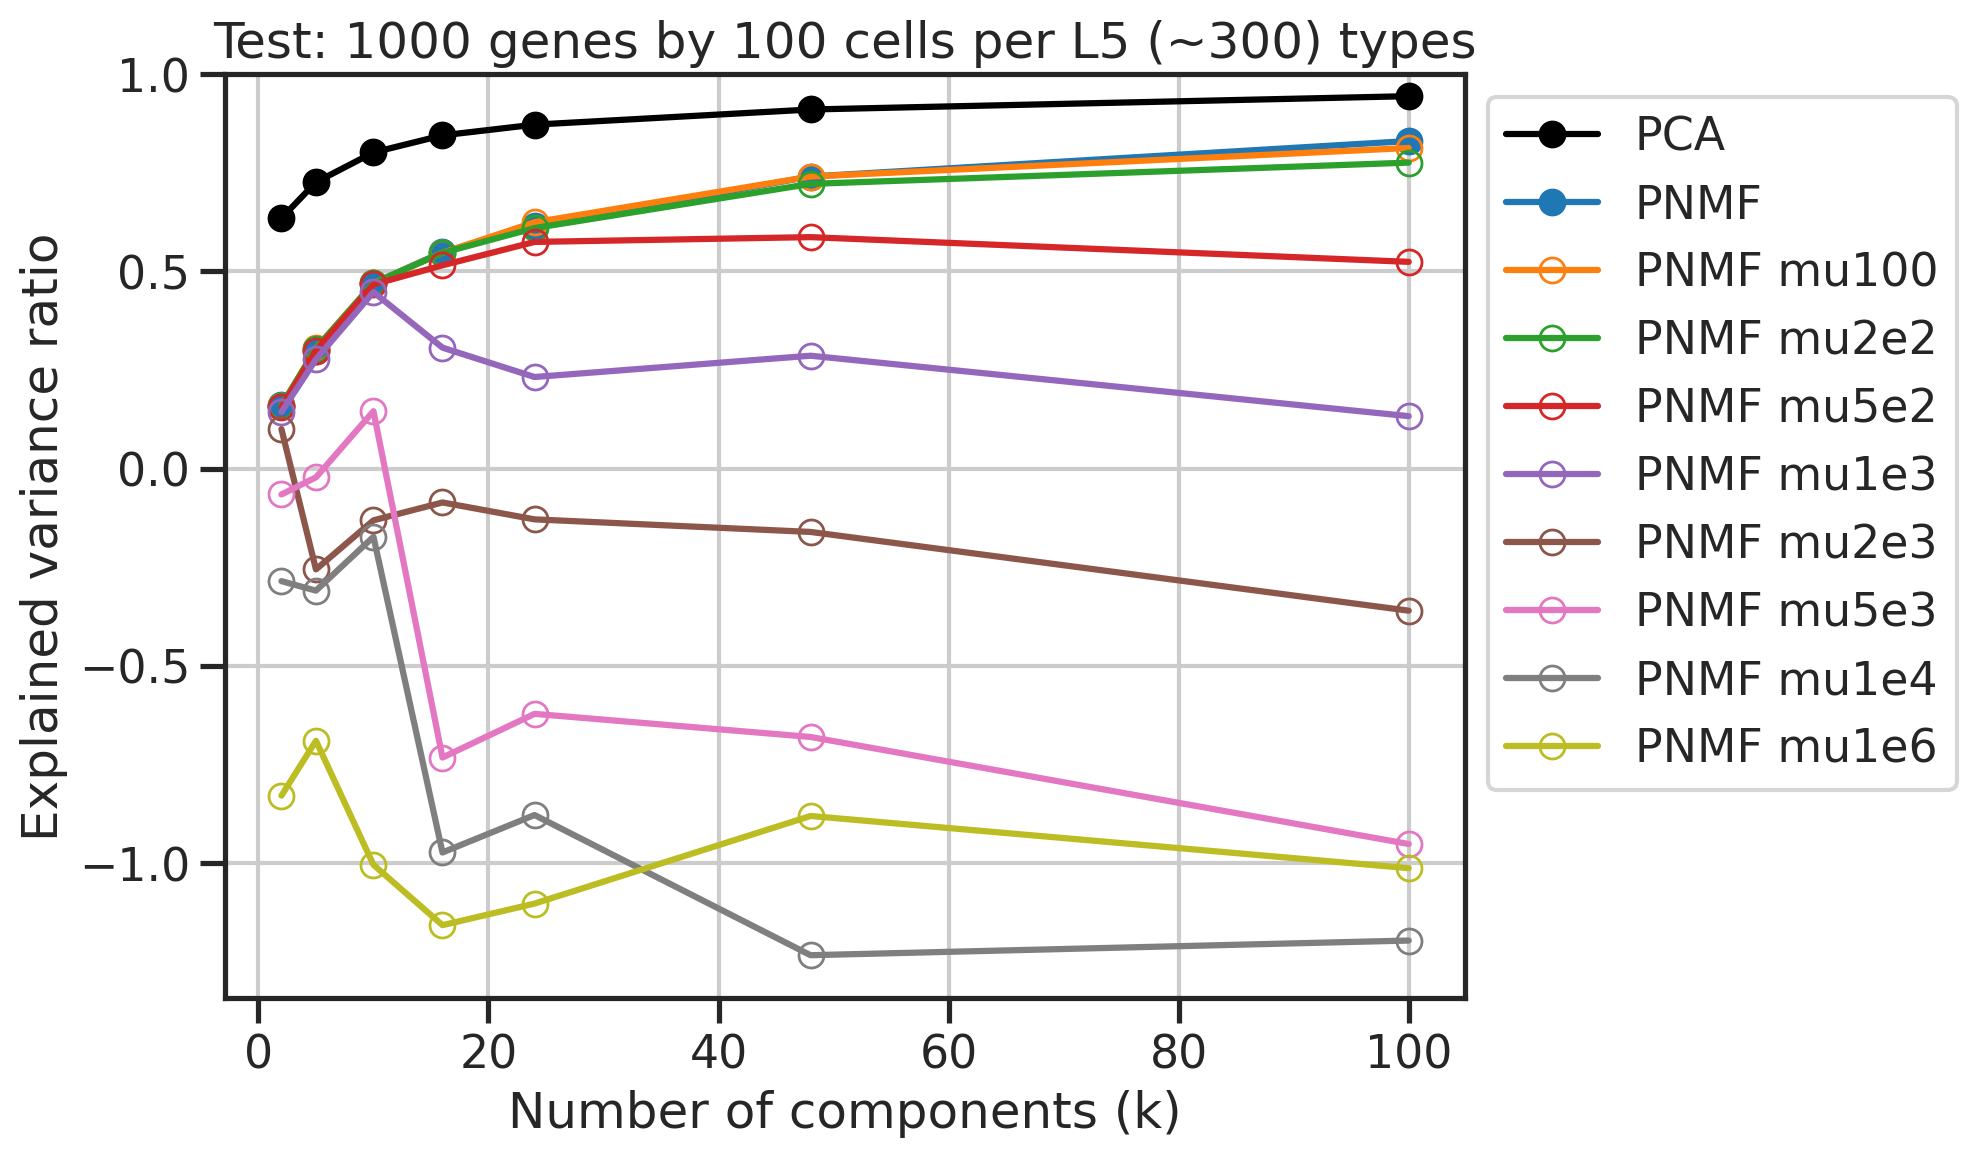

In [23]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(ks, cum_var_ratios[ks-1], '-ok', label="PCA")
ax.plot(ks, r2s, '-o', label="PNMF")

ax.plot(ks, r2s_mu1, '-o', label="PNMF mu100", fillstyle='none')
ax.plot(ks, r2s_mu4, '-o', label="PNMF mu2e2", fillstyle='none')
ax.plot(ks, r2s_mu5, '-o', label="PNMF mu5e2", fillstyle='none')

ax.plot(ks, r2s_mu6, '-o', label="PNMF mu1e3", fillstyle='none')
ax.plot(ks, r2s_mu7, '-o', label="PNMF mu2e3", fillstyle='none')
ax.plot(ks, r2s_mu8, '-o', label="PNMF mu5e3", fillstyle='none')

ax.plot(ks, r2s_mu2, '-o', label="PNMF mu1e4", fillstyle='none')
ax.plot(ks, r2s_mu3, '-o', label="PNMF mu1e6", fillstyle='none')


# ax.plot(2*ks, cum_var_ratios[ks-1], '--o', label="PCA (2x)", color='gray')
ax.set_xlabel("Number of components (k)")
ax.set_ylabel("Explained variance ratio")
ax.set_ylim([None,1])
ax.legend(bbox_to_anchor=(1,1))
ax.set_title(f"Test: {len(Xmat)} genes by 100 cells per L5 (~300) types")
plt.show()

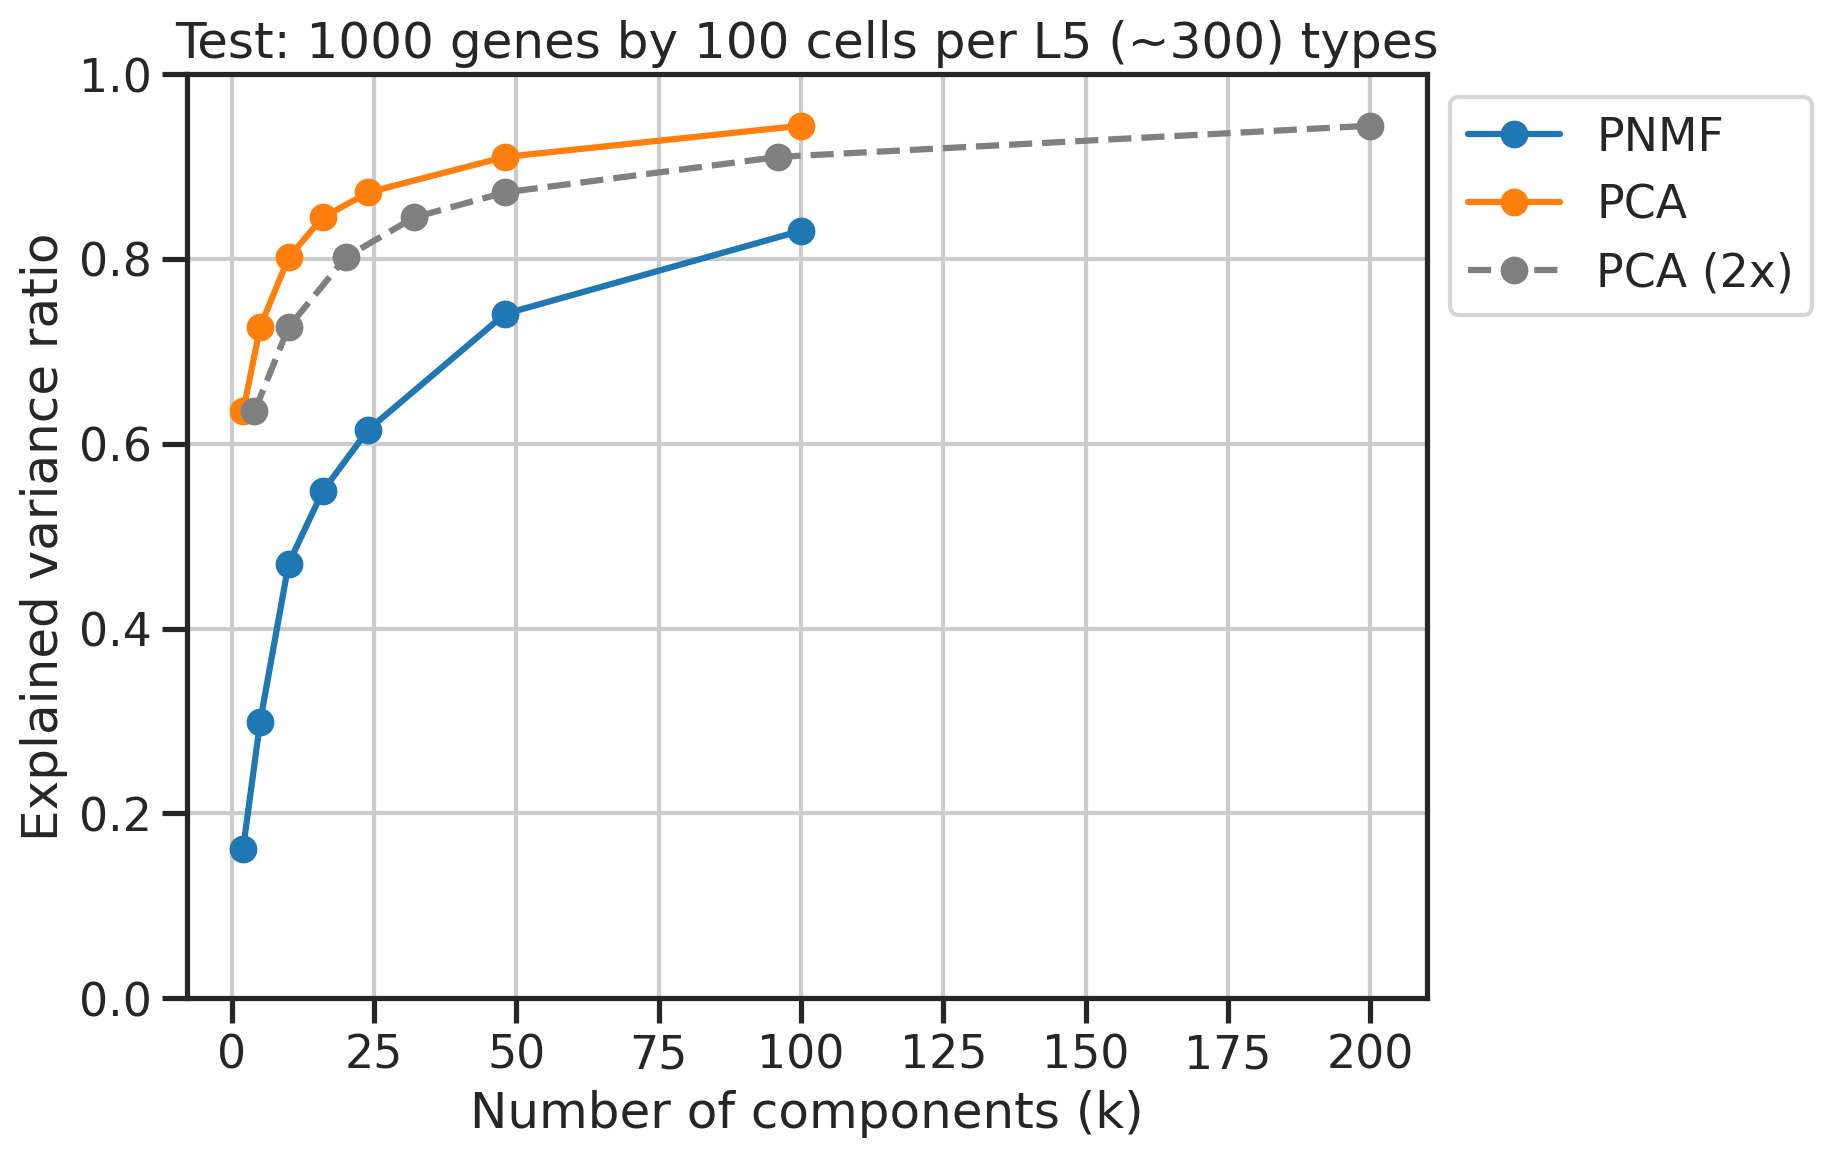

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(ks, r2s, '-o', label="PNMF")
ax.plot(ks, cum_var_ratios[ks-1], '-o', label="PCA")
ax.plot(ks*2, cum_var_ratios[ks-1], '--o', label="PCA (2x)", color='gray')
ax.set_xlabel("Number of components (k)")
ax.set_ylabel("Explained variance ratio")
ax.set_ylim([0,1])
ax.legend(bbox_to_anchor=(1,1))
ax.set_title(f"Test: {len(Xmat)} genes by 100 cells per L5 (~300) types")
plt.show()